<a href="https://colab.research.google.com/github/GuillaumeMagnette/Stage_Tritons/blob/master/Mask_RCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/matterport/Mask_RCNN.git

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 116.76 MiB | 33.08 MiB/s, done.
Resolving deltas: 100% (566/566), done.


In [0]:
!pip install h5py imgaug IPython cython

In [2]:
try:
  %tensorflow_version 1.4
except:
  pass


`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.4`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


In [3]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

import warnings
warnings.filterwarnings("ignore")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from content.Mask_RCNN.mrcnn import utils
import content.Mask_RCNN.mrcnn.model as modellib
from content.Mask_RCNN.mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import content.Mask_RCNN.samples.coco as coco
from content.Mask_RCNN.samples.coco import coco

Using TensorFlow backend.


ModuleNotFoundError: ignored

In [0]:
from google.colab import drive
!rm -rf /content/content
drive.mount('/content/drive')
#!cp '/content/drive/My Drive/slim.zip' slim.zip
!unzip -q /content/drive/"My Drive"/Stage/Database_newts.zip

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
replace database/Bascha_P01_T01_K03_F_Adult_4265_20190319190818.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [0]:
from google.colab import drive
!rm -rf /content/content
drive.mount('/content/drive')
#!cp '/content/drive/My Drive/slim.zip' slim.zip
!unzip -q /content/drive/"My Drive"/Stage/Stage_cropped.zip
!unzip -q /content/drive/"My Drive"/Stage/newtsAugmented.zip

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from google.colab import drive
!rm -rf /content/content
drive.mount('/content/drive')
#!cp '/content/drive/My Drive/slim.zip' slim.zip
#!unzip -q /content/drive/"My Drive"/Stage/newtsAugmented.zip
!unzip -q /content/drive/"My Drive"/Stage/aug_database_for_seg.zip

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!unzip -q /content/patterns_annotated.zip

In [0]:

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join('', "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

... done downloading pretrained model!


In [0]:

class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [6]:

# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir='mask_rcnn_coco.hy', config=config)

# Load weights trained on MS-COCO
model.load_weights('mask_rcnn_coco.h5', by_name=True)

NameError: ignored

In [0]:

# COCO Class names
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

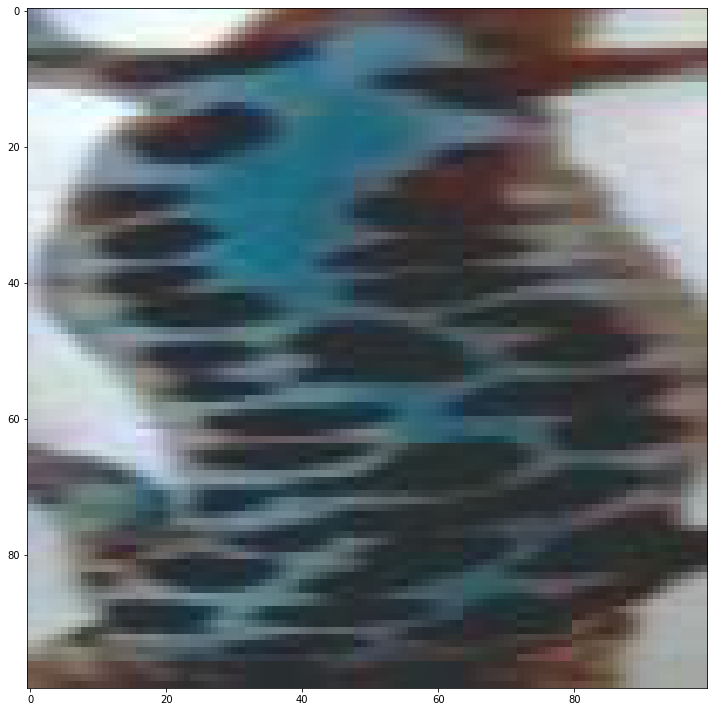

In [0]:
# Load a random image from the images folder
img_path  = '/content/database/Bascha_P01_T01_K03_F_Adult_4274_20190319211855.jpg'
img_path = '/content/database/Bascha_P01_T01_K03_F_Adult_4275_20190319212303.jpg'
img_path = '/content/content/databaseAug/train/KM00002/Bascha_P01_T02_K13_M_Adult_756_201905311224520.jpg'
img_path = '/content/content/databaseAug/test/KM00002/Bascha_P01_T02_K13_M_Adult_756_201905311224525.jpg'
image = skimage.io.imread(img_path)

# original image
plt.figure(figsize=(12,10))
skimage.io.imshow(image)

Processing 1 images
image                    shape: (100, 100, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32

*** No instances to display *** 



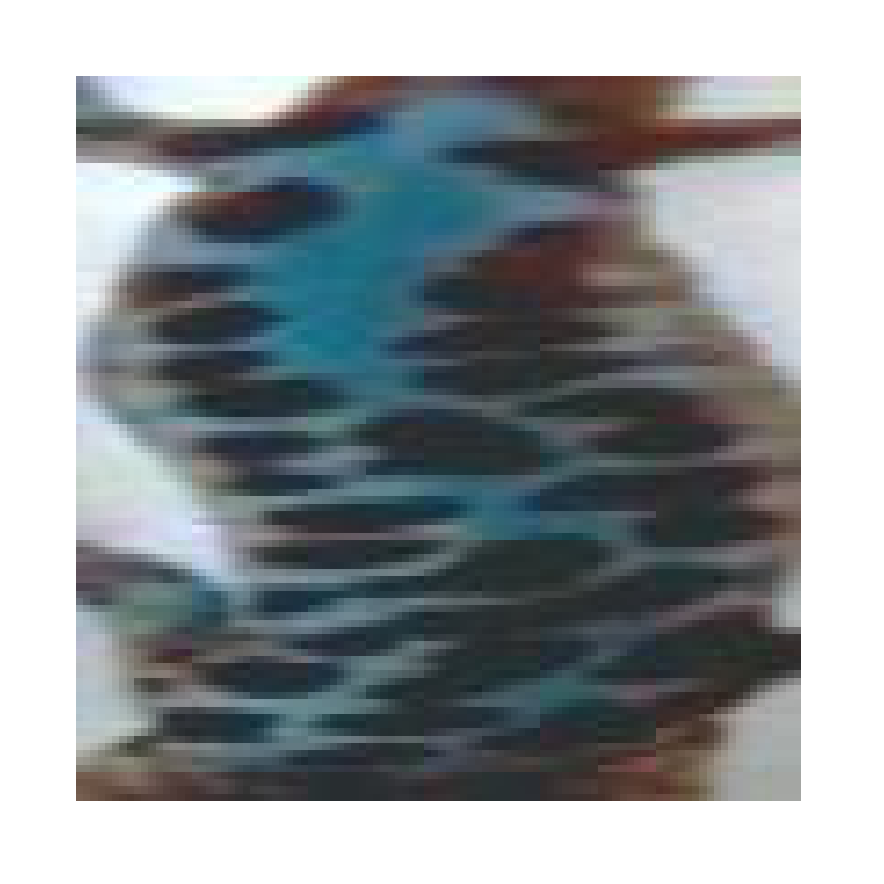

In [0]:
# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])


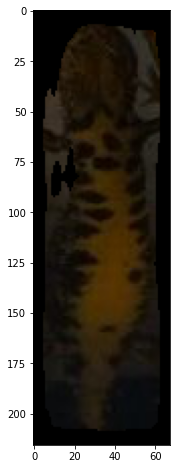

In [0]:

mask = r['masks']
mask = mask.astype(int)
mask.shape


for i in range(mask.shape[2]):
    temp = image
    for j in range(temp.shape[2]):
        temp[:,:,j] = temp[:,:,j] * mask[:,:,i]
    plt.figure(figsize=(8,8))
    plt.imshow(temp)

In [1]:
from google.colab import drive
!rm -rf /content/content
drive.mount('/content/drive')
#!cp '/content/drive/My Drive/slim.zip' slim.zip
!unzip -q /content/drive/"My Drive"/Stage/aug_database_for_seg.zip

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!git clone https://github.com/matterport/Mask_RCNN.git

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 116.76 MiB | 5.61 MiB/s, done.
Resolving deltas: 100% (566/566), done.


In [0]:
!rm -rf /content/Mask_RCNN/pattern_annotated
!unzip -q /content/pattern_annotated.zip

In [0]:
!rm -rf /content/Mask_RCNN/logs

In [2]:
try:
  %tensorflow_version 1.4
except:
  pass

import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
!pip install keras==2.2.5

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.4`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


In [3]:


import os
import sys
import json
import datetime
import numpy as np
import skimage.draw

import os
import sys
import itertools
import math
import logging
import json
import re
import random
from collections import OrderedDict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon


# Root directory of the project
ROOT_DIR = os.path.abspath("/content/Mask_RCNN")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
# Root directory of the project
#ROOT_DIR = os.getcwd()
#if ROOT_DIR.endswith("samples/balloon"):
    # Go up two levels to the repo root
   # ROOT_DIR = os.path.dirname(os.path.dirname(ROOT_DIR))

# Import Mask RCNN
#sys.path.append(ROOT_DIR)

import mrcnn.utils
import mrcnn.visualize as visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log



%matplotlib inline

Using TensorFlow backend.


In [4]:
# Root directory of the project
ROOT_DIR = os.path.abspath("/content/Mask_RCNN")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import model as modellib, utils

# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_WEIGHTS_PATH):
    utils.download_trained_weights(COCO_WEIGHTS_PATH)


# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")


... done downloading pretrained model!


In [0]:
############################################################
#  Configurations
############################################################


class NewtsConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "newt_pattern"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 2

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # Background + newts

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 100

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9


In [0]:
############################################################
#  Dataset
############################################################

class NewtsDataset(utils.Dataset):

    def load_newts(self, dataset_dir, subset):
        """Load a subset of the newts dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("newt_pattern", 1, "newt_pattern")

        # Train or validation dataset?
        #assert subset in ["train", "test"]
        #dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        # VGG Image Annotator (up to version 1.6) saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region
        # Note: In VIA 2.0, regions was changed from a dict to a list.
        #/content/images_annotated/via_export_newts.json
        annotations = json.load(open(os.path.join(dataset_dir, "via_export_newts_pattern.json")))
        annotations = list(annotations.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. These are stores in the
            # shape_attributes (see json format above)
            # The if condition is needed to support VIA versions 1.x and 2.x.
            if type(a['regions']) is dict:
                polygons = [r['shape_attributes'] for r in a['regions'].values()]
            else:
                polygons = [r['shape_attributes'] for r in a['regions']] 

            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "newt_pattern",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons)

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a newt dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "newt_pattern":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "newt_pattern":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)



In [0]:
config = NewtsConfig()
NEWTS_DIR = os.path.join(ROOT_DIR, "pattern_annotated")

In [8]:

# Load dataset
# Get the dataset from the releases page
# https://github.com/matterport/Mask_RCNN/releases
dataset = NewtsDataset()
#dataset.load_newts(IMAGE_DIR, "train")
dataset.load_newts(NEWTS_DIR, "train")
# Must call before using the dataset
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 80
Class Count: 2
  0. BG                                                
  1. newt_pattern                                      


In [9]:
dataset.load_image(np.random.choice(dataset.image_ids, 1)[0])


SyntaxError: ignored

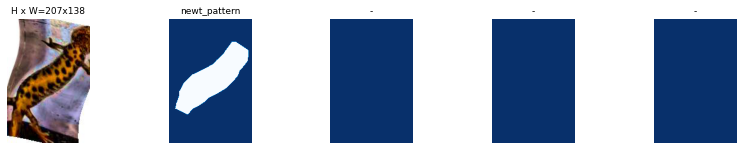

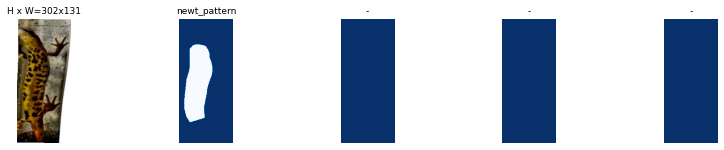

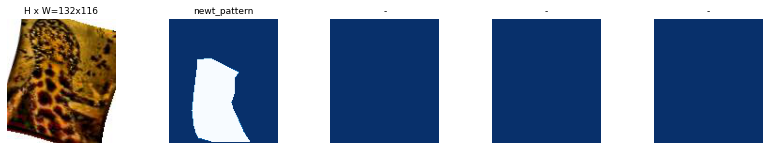

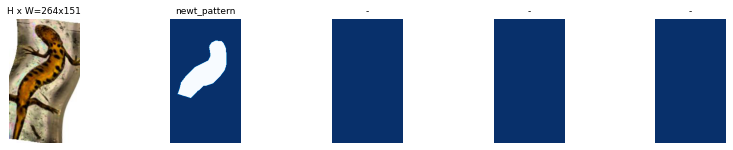

In [10]:
# Load and display random samples
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

image_id  44 /content/Mask_RCNN/pattern_annotated/Bascha_P01_T06_K20_U_Adult_8012_20190719220609.jpg
image                    shape: (181, 65, 3)          min:    0.00000  max:  255.00000  uint8
mask                     shape: (181, 65, 1)          min:    0.00000  max:    1.00000  bool
class_ids                shape: (1,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (1, 4)                min:    0.00000  max:  152.00000  int32


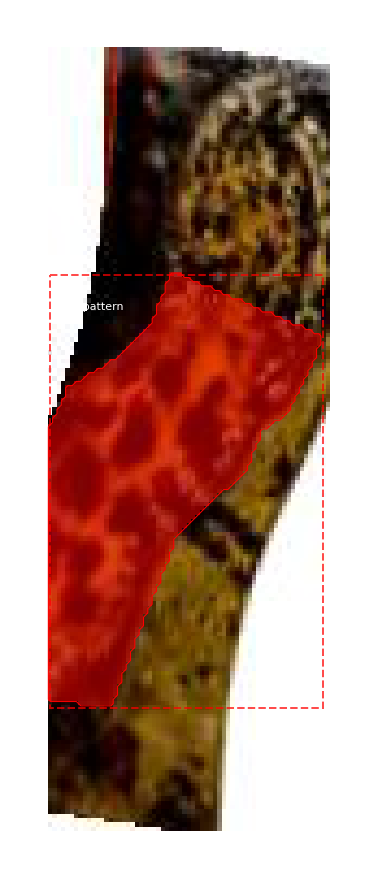

In [11]:
#Load random image and mask.
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

In [18]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

def train(model):
    """Train the model."""
    # Training dataset.
    dataset_train = NewtsDataset()
    dataset_train.load_newts(NEWTS_DIR, "train")
    dataset_train.prepare()

    # Validation dataset
    dataset_val = NewtsDataset()
    dataset_val.load_newts(NEWTS_DIR, "val")
    dataset_val.prepare()

    # *** This training schedule is an example. Update to your needs ***
    # Since we're using a very small dataset, and starting from
    # COCO trained weights, we don't need to train too long. Also,
    # no need to train all layers, just the heads should do it.
    print("Training network heads")
    #model.metrics_tensors = []
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=60,
                layers='heads')

model = modellib.MaskRCNN(mode="training", config=config,
                                  model_dir=DEFAULT_LOGS_DIR)
weights_path = '/content/Mask_RCNN/logs/newt_pattern20200602T1046/mask_rcnn_newt_pattern_0040.h5'
model.load_weights(weights_path, by_name=True)




OSError: ignored

In [0]:
#train(model)
dataset_train = NewtsDataset()


In [0]:
class InferenceConfig(NewtsConfig):
            # Set batch size to 1 since we'll be running inference on
            # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
            GPU_COUNT = 1
            IMAGES_PER_GPU = 1

model = modellib.MaskRCNN(mode="inference", config=config,
                                  model_dir=DEFAULT_LOGS_DIR)
weights_path = '/content/Mask_RCNN/logs/newt_pattern20200602T1046/mask_rcnn_newt_pattern_0060.h5'
model.load_weights(weights_path, by_name=True)

config = InferenceConfig()

Re-starting from epoch 60


In [0]:
def color_splash(image, mask):
    """Apply color splash effect.
    image: RGB image [height, width, 3]
    mask: instance segmentation mask [height, width, instance count]
    Returns result image.
    """
    # Make a grayscale copy of the image. The grayscale copy still
    # has 3 RGB channels, though.
    gray = skimage.color.gray2rgb(skimage.color.rgb2gray(image)) * 255
    # Copy color pixels from the original color image where mask is set
    if mask.shape[-1] > 0:
        # We're treating all instances as one, so collapse the mask into one layer
        mask = (np.sum(mask, -1, keepdims=True) >= 1)
        splash = np.where(mask, image, gray).astype(np.uint8)
    else:
        splash = gray.astype(np.uint8)
    return splash

def detect_and_color_splash(model, image_path=None, video_path=None):
    assert image_path or video_path

    # Image or video?
    if image_path:
        # Run model detection and generate the color splash effect
        print("Running on {}".format(img_path))
        # Read image
        image = skimage.io.imread(img_path)
        # Detect objects
        r = model.detect([image], verbose=1)[0]
        # Color splash
        splash = color_splash(image, r['masks'])
        # Save output
        file_name = "splash_{:%Y%m%dT%H%M%S}.png".format(datetime.datetime.now())
        skimage.io.imsave(file_name, splash)
        plt.imshow(splash)
    elif video_path:
        import cv2
        # Video capture
        vcapture = cv2.VideoCapture(video_path)
        width = int(vcapture.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(vcapture.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = vcapture.get(cv2.CAP_PROP_FPS)

        # Define codec and create video writer
        file_name = "splash_{:%Y%m%dT%H%M%S}.avi".format(datetime.datetime.now())
        vwriter = cv2.VideoWriter(file_name,
                                  cv2.VideoWriter_fourcc(*'MJPG'),
                                  fps, (width, height))

        count = 0
        success = True
        while success:
            print("frame: ", count)
            # Read next image
            success, image = vcapture.read()
            if success:
                # OpenCV returns images as BGR, convert to RGB
                image = image[..., ::-1]
                # Detect objects
                r = model.detect([image], verbose=0)[0]
                # Color splash
                splash = color_splash(image, r['masks'])
                # RGB -> BGR to save image to video
                splash = splash[..., ::-1]
                # Add image to video writer
                vwriter.write(splash)
                count += 1
        vwriter.release()
    print("Saved to ", file_name)



Running on /content/aug_database_for_seg/Bascha_P01_T06_K17_U_Juvenile_6664_20190628041159.jpg
Processing 1 images
image                    shape: (208, 54, 3)          min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Saved to  splash_20200602T152214.png


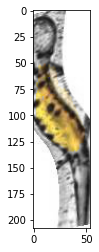

In [0]:
img_path = '/content/aug_database_for_seg/Bascha_P01_T06_K17_U_Juvenile_6664_20190628041159.jpg'
detect_and_color_splash(model, image_path=img_path, video_path=None)

Processing 1 images
image                    shape: (255, 131, 3)         min:    0.00000  max:  123.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:   -3.70000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


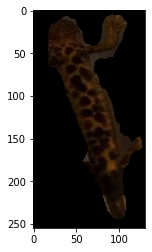

In [0]:
import skimage
from skimage import measure

#measure.label()
def extract_image(img_path):
  image = skimage.io.imread(img_path)
  # Detect objects
  r = model.detect([image], verbose=1)[0]

  

  # Extract the greatest region 

  labels_mask = measure.label(r['masks'])  
  #print(labels_mask)                 
  #print(labels_mask.astype(np.uint8))
  #plt.imshow(np.squeeze(labels_mask.astype(np.uint8)))
  #regions = measure.regionprops(np.squeeze(labels_mask.astype(np.uint8)))
  regions = measure.regionprops(labels_mask)
  regions.sort(key=lambda x: x.area, reverse=True)
  #print(regions)
  #print(len(regions))
  if len(regions) > 1:
    for rg in regions[1:]:
        labels_mask[rg.coords[:,0], rg.coords[:,1]] = 0


  labels_mask[labels_mask!=0] = 1
  mask = labels_mask
  #plt.imshow(np.squeeze(mask))

  if mask.shape[-1] > 0:
    # We're treating all instances as one, so collapse the mask into one layer
    mask = (np.sum(mask, -1, keepdims=True) >= 1)
    img_extracted = np.where(mask, image, 0).astype(np.uint8)
  
  # Save output
  file_name = "newt_{:%Y%m%dT%H%M%S}.png".format(datetime.datetime.now())
  skimage.io.imsave(file_name, img_extracted)
  plt.imshow(img_extracted)

image_extracted = extract_image(img_path)

Processing 1 images
image                    shape: (285, 96, 3)          min:    0.00000  max:  109.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  -15.70000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


TypeError: ignored